In [1]:
import sys
import pickle
import torch
print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['..//', '..\\'])
print("Torch version: %s" % torch.__version__)

Python 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)] on win32
Torch version: 2.0.1+cu118


# Classification net

In [2]:
from torch.utils.data import Dataset
from torch import nn
import utils


output_size = 130


class EmbeddingDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, output_size)
        )

    def forward(self, data):
        res = self.net(data)
        return res


class MergeMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.codes = MLP()
        self.docs = MLP()
        self.requirement = MLP()
        self.readme = MLP()
        self.net = nn.Sequential(
            nn.Linear(output_size * 4, output_size)
        )

    def forward(self, data):
        codes = self.codes(data[:, :768])
        docs = self.docs(data[:, 768:768*2])
        requirement = self.requirement(data[:, 768*2:768*3])
        readme = self.readme(data[:, 768*3:])
        bigData = torch.cat([codes, docs, requirement, readme], dim=1)
        res = self.net(bigData)
        return res


def build_embedding_sets(filename, unique_labels=None):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    repo_names = list(data.keys())
    embedding_types = list(data[repo_names[0]].keys())[-5:]
    mean_embeddings = {}
    labels = []

    for embedding in embedding_types:
        mean_embeddings[embedding] = []

    for repo in repo_names:
        if unique_labels and data[repo]['topic'] not in unique_labels:
            continue
        labels.append(data[repo]['topic'])
        for embedding in embedding_types:
            mean_embeddings[embedding].append(utils.mean_embeddings(data[repo][embedding]))

    return mean_embeddings, labels

In [53]:
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_types = ['codes_embeddings', 'docs_embeddings', 'structure_embeddings', 'requirements_embeddings', 'readme_embeddings']
train_embeddings, trainLabels = build_embedding_sets("..\\Dataset\\repo_info_train_embeddings_reduce.pkl")
test_embeddings, testLabels = build_embedding_sets("..\\Dataset\\repo_info_test_embeddings_reduce.pkl")
valid_embeddings, validLabels = build_embedding_sets("..\\Dataset\\repo_info_validation_embeddings_reduce.pkl")
unique_labels = {}
set_labels = trainLabels + testLabels + validLabels
for label in set_labels:
    if label not in unique_labels:
        unique_labels[label] = 1
    else:
        unique_labels[label] += 1

print(len(unique_labels))
print(unique_labels)
unique_labels = list(unique_labels.keys())
labels_encoder = LabelEncoder()
labels_encoder.fit(unique_labels)
train_labels = labels_encoder.transform(trainLabels)
test_labels = labels_encoder.transform(testLabels)
valid_labels = labels_encoder.transform(validLabels)

130
{'Admin Panels': 7, 'Mock': 6, 'Design Patterns': 3, 'Data Validation': 5, 'Image Processing': 11, 'Compatibility': 1, 'Files': 5, 'Shell': 1, 'Office': 8, 'CLI Enhancements': 6, 'Data Analysis': 4, 'Tagging': 1, 'Mail Servers': 2, 'Terminal Rendering': 5, 'Code Analysis': 5, 'HTTP Clients': 6, 'Caching': 4, 'Package Repositories': 3, 'Date and Time': 8, 'Framework agnostic': 6, 'Productivity CLI Tools': 9, 'Unique identifiers': 2, 'Downloader': 3, 'Environment Management': 2, 'HTML Manipulation': 6, 'Profiler': 5, 'Machine Learning': 6, 'Web Crawling': 6, 'Forms': 6, 'Miscellaneous': 5, 'Natural Language Processing': 8, 'Algorithms': 4, 'Serialization': 3, 'Third-party APIs': 6, 'Geolocation': 4, 'OAuth': 6, 'Permissions': 2, 'Asynchronous Clients': 1, 'Network Virtualization': 3, 'Database Drivers': 1, 'Relational Databases': 6, 'Web Content Extracting': 9, 'Task Queues': 4, 'Science': 7, 'JWT': 3, 'SSH-style Deployment': 3, 'Package Management': 3, 'Job Scheduler': 6, 'Slugify':

Training starting
Epoch: 20, train loss: 0.464, validation loss: 0.493, train acc: 0.130, validation acc: 0.019
7693.0 examples/sec on cuda total training time:0.4 sec
Epoch: 40, train loss: 0.442, validation loss: 0.490, train acc: 0.390, validation acc: 0.044
9918.0 examples/sec on cuda total training time:0.7 sec
Epoch: 60, train loss: 0.421, validation loss: 0.486, train acc: 0.500, validation acc: 0.060
9112.1 examples/sec on cuda total training time:0.9 sec
Epoch: 80, train loss: 0.399, validation loss: 0.483, train acc: 0.570, validation acc: 0.083
9091.2 examples/sec on cuda total training time:1.1 sec
Epoch: 100, train loss: 0.377, validation loss: 0.480, train acc: 0.590, validation acc: 0.095
8346.4 examples/sec on cuda total training time:1.3 sec
Epoch: 120, train loss: 0.355, validation loss: 0.479, train acc: 0.590, validation acc: 0.102
8317.9 examples/sec on cuda total training time:1.6 sec
Epoch: 140, train loss: 0.333, validation loss: 0.477, train acc: 0.600, validat

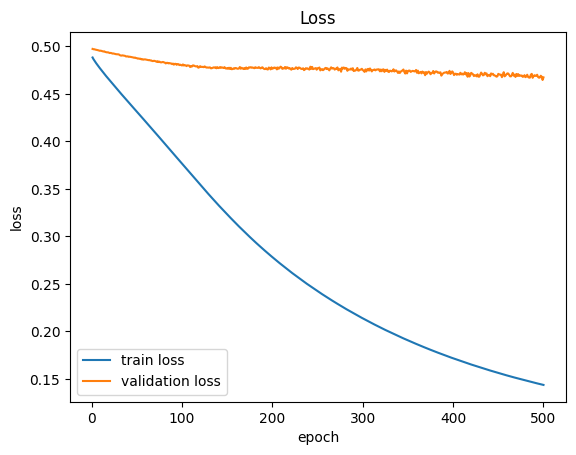

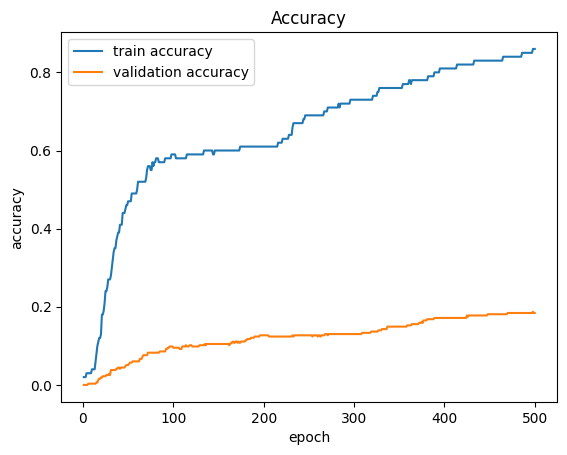

codes_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.465, validation loss: 0.490, train acc: 0.080, validation acc: 0.019
9088.8 examples/sec on cuda total training time:0.2 sec
Epoch: 40, train loss: 0.444, validation loss: 0.487, train acc: 0.440, validation acc: 0.048
9999.1 examples/sec on cuda total training time:0.5 sec
Epoch: 60, train loss: 0.423, validation loss: 0.484, train acc: 0.550, validation acc: 0.073
7689.3 examples/sec on cuda total training time:0.7 sec
Epoch: 80, train loss: 0.402, validation loss: 0.483, train acc: 0.600, validation acc: 0.073
5555.1 examples/sec on cuda total training time:1.0 sec
Epoch: 100, train loss: 0.382, validation loss: 0.479, train acc: 0.650, validation acc: 0.076
7692.6 examples/sec on cuda total training time:1.2 sec
Epoch: 120, train loss: 0.362, validation loss: 0.477, train acc: 0.680, validation acc: 0.079
8536.5 examples/sec on cuda total training time:1.4 sec
Epoch: 140, train loss: 0.342, v

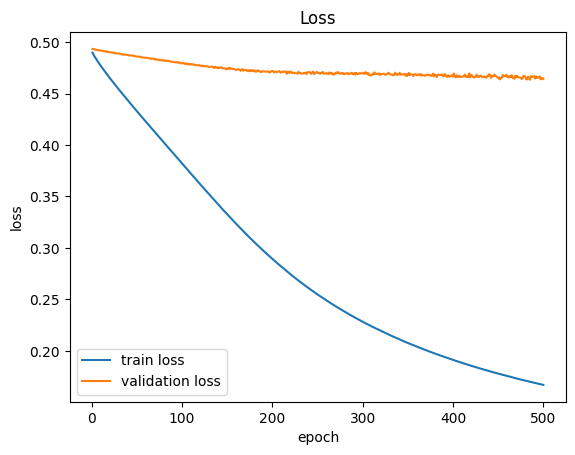

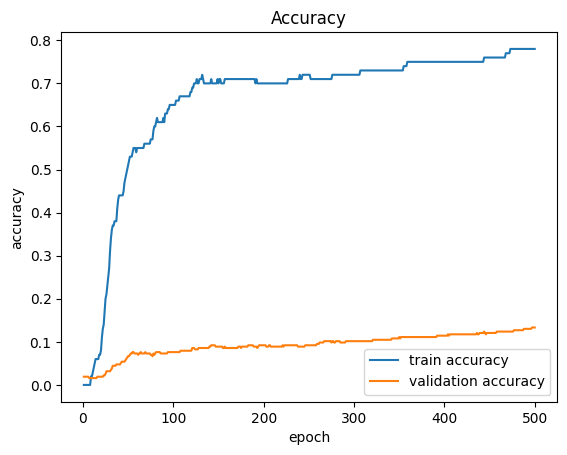

docs_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.477, validation loss: 0.496, train acc: 0.030, validation acc: 0.013
8300.9 examples/sec on cuda total training time:0.2 sec
Epoch: 40, train loss: 0.467, validation loss: 0.496, train acc: 0.060, validation acc: 0.010
7621.8 examples/sec on cuda total training time:0.5 sec
Epoch: 60, train loss: 0.456, validation loss: 0.497, train acc: 0.070, validation acc: 0.006
8333.8 examples/sec on cuda total training time:0.7 sec
Epoch: 80, train loss: 0.446, validation loss: 0.498, train acc: 0.090, validation acc: 0.000
10000.5 examples/sec on cuda total training time:0.9 sec
Epoch: 100, train loss: 0.435, validation loss: 0.500, train acc: 0.100, validation acc: 0.013
11110.7 examples/sec on cuda total training time:1.2 sec
Epoch: 120, train loss: 0.426, validation loss: 0.504, train acc: 0.100, validation acc: 0.013
7691.3 examples/sec on cuda total training time:1.4 sec
Epoch: 140, train loss: 0.418, 

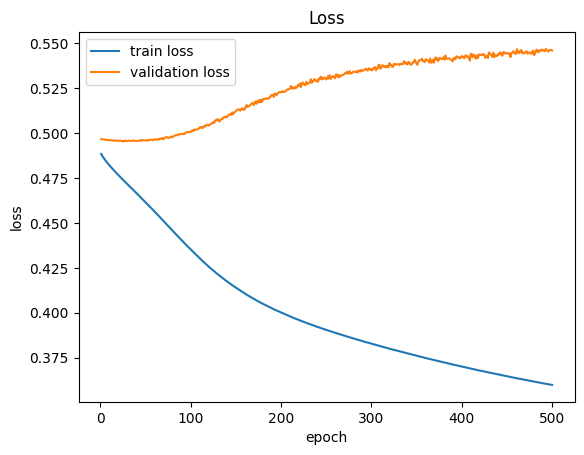

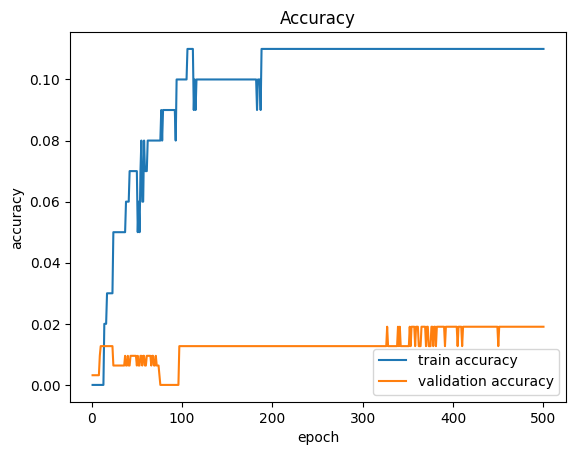

structure_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.472, validation loss: 0.494, train acc: 0.100, validation acc: 0.022
11004.6 examples/sec on cuda total training time:0.2 sec
Epoch: 40, train loss: 0.457, validation loss: 0.493, train acc: 0.230, validation acc: 0.016
8333.9 examples/sec on cuda total training time:0.4 sec
Epoch: 60, train loss: 0.442, validation loss: 0.494, train acc: 0.230, validation acc: 0.010
9101.2 examples/sec on cuda total training time:0.7 sec
Epoch: 80, train loss: 0.427, validation loss: 0.495, train acc: 0.250, validation acc: 0.013
10004.3 examples/sec on cuda total training time:0.9 sec
Epoch: 100, train loss: 0.412, validation loss: 0.497, train acc: 0.220, validation acc: 0.013
9990.0 examples/sec on cuda total training time:1.1 sec
Epoch: 120, train loss: 0.398, validation loss: 0.501, train acc: 0.260, validation acc: 0.016
9896.9 examples/sec on cuda total training time:1.3 sec
Epoch: 140, train loss: 0.

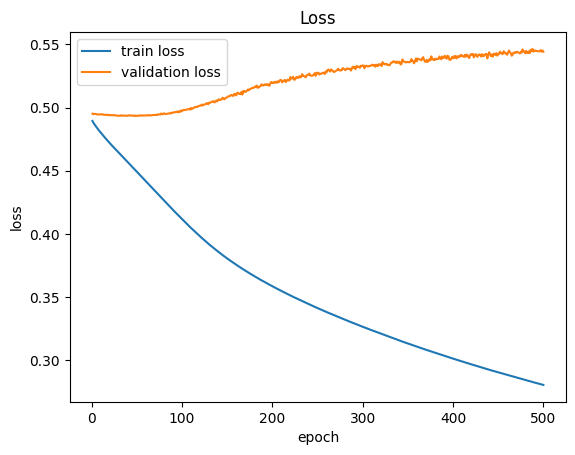

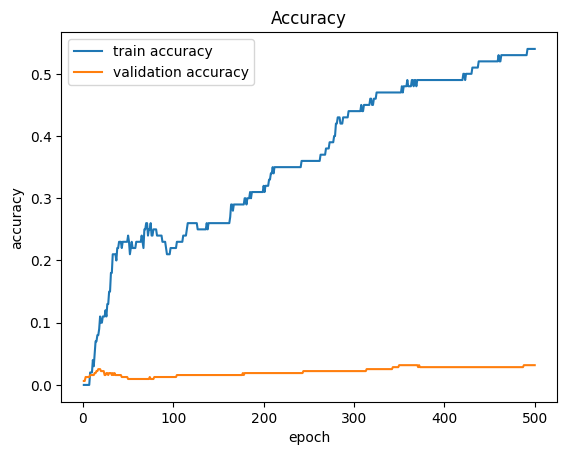

requirements_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.440, validation loss: 0.496, train acc: 0.190, validation acc: 0.013
7692.6 examples/sec on cuda total training time:0.3 sec
Epoch: 40, train loss: 0.394, validation loss: 0.492, train acc: 0.510, validation acc: 0.029
11215.9 examples/sec on cuda total training time:0.5 sec
Epoch: 60, train loss: 0.351, validation loss: 0.490, train acc: 0.680, validation acc: 0.029
9090.6 examples/sec on cuda total training time:0.7 sec
Epoch: 80, train loss: 0.310, validation loss: 0.488, train acc: 0.760, validation acc: 0.051
9090.4 examples/sec on cuda total training time:0.9 sec
Epoch: 100, train loss: 0.272, validation loss: 0.488, train acc: 0.770, validation acc: 0.054
9091.8 examples/sec on cuda total training time:1.2 sec
Epoch: 120, train loss: 0.238, validation loss: 0.488, train acc: 0.840, validation acc: 0.063
9047.1 examples/sec on cuda total training time:1.4 sec
Epoch: 140, train loss: 

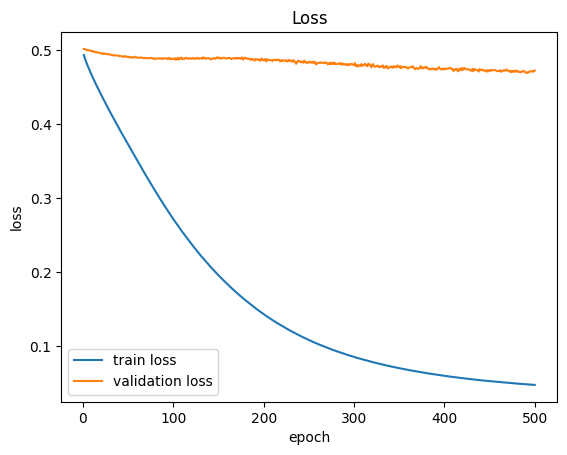

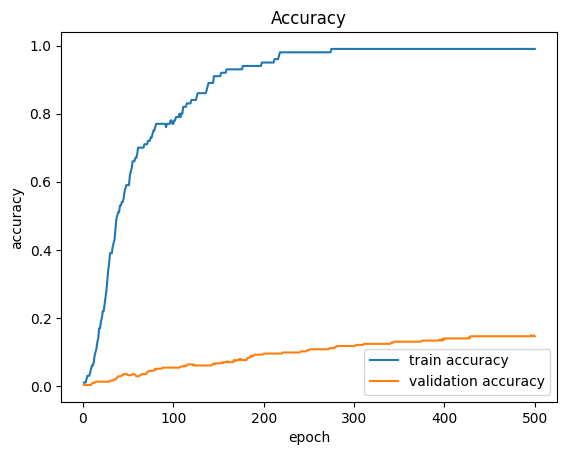

readme_embeddings
------------------------------


In [57]:
from utils import train_model, drawGraph
from torch.utils.data import DataLoader

batch_size = 10
epochs = 500
lr = 0.00001
weight_decay = 0.1


for embedding_name in embedding_types:
    train_embedding = train_embeddings[embedding_name]
    valid_embedding = valid_embeddings[embedding_name]
    train_dataset = EmbeddingDataset(train_embedding, train_labels)
    valid_dataset = EmbeddingDataset(valid_embedding, valid_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    net = MLP()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay, betas=(0.8, 0.9))
    train_loss, test_loss, train_acc, test_acc = train_model(net, loss_fn, optimizer, epochs, device, valid_loader, train_loader, log_num=20, init=False)
    drawGraph(train_loss, test_loss, train_acc, test_acc)
    print(embedding_name)
    print("-"*30)

torch.Size([315, 3072])
torch.Size([100, 3072])
Training starting
Epoch: 20, train loss: 0.037, validation loss: 0.468, train acc: 1.000, validation acc: 0.130
4545.1 examples/sec on cuda total training time:0.7 sec
Epoch: 40, train loss: 0.035, validation loss: 0.460, train acc: 1.000, validation acc: 0.149
4446.3 examples/sec on cuda total training time:1.2 sec
Epoch: 60, train loss: 0.038, validation loss: 0.465, train acc: 1.000, validation acc: 0.171
4545.4 examples/sec on cuda total training time:1.6 sec
Epoch: 80, train loss: 0.041, validation loss: 0.472, train acc: 1.000, validation acc: 0.165
4764.8 examples/sec on cuda total training time:2.0 sec
Epoch: 100, train loss: 0.043, validation loss: 0.479, train acc: 1.000, validation acc: 0.165
4541.8 examples/sec on cuda total training time:2.5 sec
Epoch: 120, train loss: 0.043, validation loss: 0.486, train acc: 1.000, validation acc: 0.149
4764.9 examples/sec on cuda total training time:2.9 sec
Epoch: 140, train loss: 0.042, v

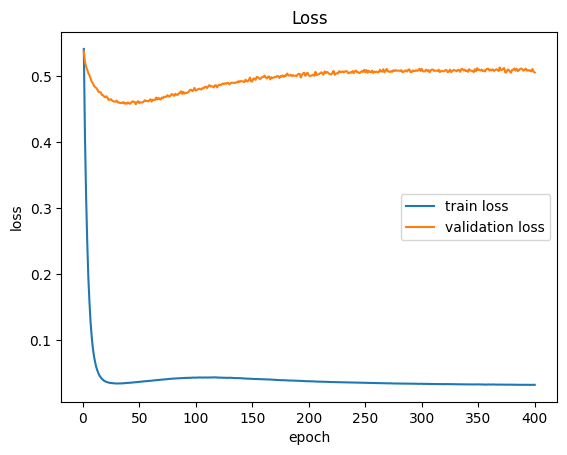

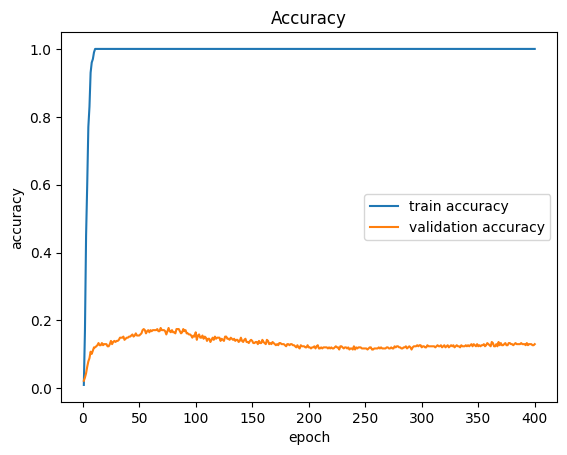

In [58]:
from utils import train_model, drawGraph
from torch.utils.data import DataLoader

batch_size = 10
epochs = 400
lr = 0.0001
weight_decay = 0.1

train_embedding_list = []
valid_embedding_list = []
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
for embedding_name in embedding_types:
    train_embedding_list.append(torch.stack(train_embeddings[embedding_name], dim=0))
    valid_embedding_list.append(torch.stack(valid_embeddings[embedding_name], dim=0))

train_embedding = torch.cat(train_embedding_list, dim=1)
valid_embedding = torch.cat(valid_embedding_list, dim=1)
print(train_embedding.shape)
print(valid_embedding.shape)

train_dataset = EmbeddingDataset(train_embedding, train_labels)
valid_dataset = EmbeddingDataset(valid_embedding, valid_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

net = MergeMLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
train_loss, test_loss, train_acc, test_acc = train_model(net, loss_fn, optimizer, epochs, device, valid_loader, train_loader, log_num=20)
drawGraph(train_loss, test_loss, train_acc, test_acc)

# Biclassification net

In [6]:
from torch.utils.data import Dataset
from torch import nn
import utils
from torch.nn import functional as F
import random

class PairDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return torch.cat(self.data[index], dim=0), self.labels[index]


class SingleEmbeddingClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 300)
        )
        self.classifier = nn.Sequential(
            nn.Linear(300 * 2, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, 2),
        )

    def forward(self, data):
        e1 = data[:, :768]
        e2 = data[:, 768:]
        res1 = self.net(e1)
        res2 = self.net(e2)
        res = torch.cat([res1,res2], dim=1)
        res = self.classifier(res)
        return res


def mergeEmbedding(sets_list, labels_list, embedding_types):
    all_embeddings_set = {}
    all_labels = []
    for t in embedding_types:
        all_embeddings_set[t] = []

    for embedding_set in sets_list:
        for t in embedding_types:
            all_embeddings_set[t] = all_embeddings_set[t] + embedding_set[t]
    for labels_set in labels_list:
        all_labels = all_labels + labels_set

    return all_embeddings_set, all_labels

def build_embedding_sets(filename, unique_labels=None):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    repo_names = list(data.keys())
    embedding_types = list(data[repo_names[0]].keys())[-5:]
    mean_embeddings = {}
    labels = []

    for embedding in embedding_types:
        mean_embeddings[embedding] = []

    for repo in repo_names:
        if unique_labels and data[repo]['topic'] not in unique_labels:
            continue
        labels.append(data[repo]['topic'])
        for embedding in embedding_types:
            mean_embeddings[embedding].append(utils.mean_embeddings(data[repo][embedding]))

    return mean_embeddings, labels


def build_pair_data(data, labels, embedding_types, balanced=1.0):
    pair_embeddings = {}
    pair_labels = []

    def make_pair(idx1, idx2):
        if labels[idx1] != labels[idx2]:
            pair_labels.append(0)
        else:
            pair_labels.append(1)
        for embedding_type in embedding_types:
            e1 = data[embedding_type][idx1]
            e2 = data[embedding_type][idx2]
            pair_embeddings[embedding_type].append((e1, e2))

    for embedding_type in embedding_types:
        pair_embeddings[embedding_type] = []

    for i in range(len(labels)):
        make_pair(i, i)
        for j in range(i+1, len(labels)):
            make_pair(i, j)
            make_pair(j, i)

    if balanced:
        print("Before balanced:", len(pair_labels))
        c0_index = []
        c1_index = []
        for i in range(len(pair_labels)):
            if pair_labels[i] == 0:
                c0_index.append(i)
            else:
                c1_index.append(i)

        c0_num = len(c0_index)
        c1_num = len(c1_index)

        if c0_num > c1_num:
            c0_num = min(int(c1_num * balanced), c0_num)
            c0_index = random.sample(c0_index, c0_num)
        else:
            c1_num = min(int(c0_num * balanced), c1_num)
            c1_index = random.sample(c1_index, c1_num)

        print("C 0:", c0_num)
        print("C 1:", c1_num)

        balanced_index = c0_index + c1_index

        balanced_embeddings = {}
        balanced_labels = []
        for embedding_type in embedding_types:
            balanced_embeddings[embedding_type] = []


        for i in balanced_index:
            balanced_labels.append(pair_labels[i])
            for embedding_type in embedding_types:
                balanced_embeddings[embedding_type].append(pair_embeddings[embedding_type][i])

        pair_embeddings = balanced_embeddings
        pair_labels = balanced_labels
        print("After balanced:", len(pair_labels))

    return pair_embeddings, pair_labels


def split_pair_embeddings(pair_embeddings, pair_labels, train_test_ratio=0.8):
    half_index = len(pair_labels)//2
    split_index = int(train_test_ratio * half_index)
    train_pairs = {}
    valid_pairs = {}
    train_labels = pair_labels[:split_index] + pair_labels[half_index:half_index + split_index]
    valid_labels = pair_labels[split_index:half_index] + pair_labels[half_index + split_index:]
    for t in list(pair_embeddings.keys()):
        train_pairs[t] = pair_embeddings[t][:split_index] + pair_embeddings[t][half_index:half_index + split_index]
        valid_pairs[t] = pair_embeddings[t][split_index:half_index] + pair_embeddings[t][half_index + split_index:]
    print("Train set size:", len(train_labels))
    print("Validation set size:", len(valid_labels))
    return train_pairs, valid_pairs, train_labels, valid_labels

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_types = ['codes_embeddings', 'docs_embeddings', 'structure_embeddings', 'requirements_embeddings', 'readme_embeddings']
train_embeddings, trainLabels = build_embedding_sets("..\\Dataset\\repo_info_train_embeddings_reduce.pkl")
test_embeddings, testLabels = build_embedding_sets("..\\Dataset\\repo_info_test_embeddings_reduce.pkl")
valid_embeddings, validLabels = build_embedding_sets("..\\Dataset\\repo_info_validation_embeddings_reduce.pkl")

train_pair_embeddings, train_labels = build_pair_data(train_embeddings, trainLabels, embedding_types, balanced=1)
test_pair_embeddings, test_labels = build_pair_data(test_embeddings, testLabels, embedding_types, balanced=1)
valid_pair_embeddings, valid_labels = build_pair_data(valid_embeddings, validLabels, embedding_types, balanced=1)

all_embeddings, allLabels = mergeEmbedding([train_embeddings, test_embeddings, valid_embeddings], [trainLabels, testLabels, validLabels], embedding_types)
all_pair_embeddings, all_labels = build_pair_data(all_embeddings, allLabels, embedding_types, balanced=1)
train_pair_embeddings, valid_pair_embeddings, train_labels, valid_labels = split_pair_embeddings(all_pair_embeddings, all_labels)

Before balanced: 99225
C 0: 1173
C 1: 1173
After balanced: 2346
Before balanced: 1681
C 0: 59
C 1: 59
After balanced: 118
Before balanced: 10000
C 0: 192
C 1: 192
After balanced: 384
Before balanced: 207936
C 0: 2242
C 1: 2242
After balanced: 4484
Train set size: 3586
Validation set size: 898


cuda
Training starting
Epoch: 20, train loss: 0.010, validation loss: 0.012, train acc: 0.651, validation acc: 0.565
18952.1 examples/sec on cuda total training time:5.3 sec
Epoch: 40, train loss: 0.008, validation loss: 0.012, train acc: 0.740, validation acc: 0.597
19264.9 examples/sec on cuda total training time:9.1 sec
Epoch: 60, train loss: 0.007, validation loss: 0.010, train acc: 0.795, validation acc: 0.638
20176.9 examples/sec on cuda total training time:12.8 sec
Epoch: 80, train loss: 0.007, validation loss: 0.010, train acc: 0.831, validation acc: 0.658
21149.8 examples/sec on cuda total training time:16.4 sec
Epoch: 100, train loss: 0.007, validation loss: 0.010, train acc: 0.847, validation acc: 0.645
22132.1 examples/sec on cuda total training time:20.0 sec
Epoch: 120, train loss: 0.006, validation loss: 0.010, train acc: 0.862, validation acc: 0.655
22184.4 examples/sec on cuda total training time:23.1 sec
Epoch: 140, train loss: 0.006, validation loss: 0.010, train acc:

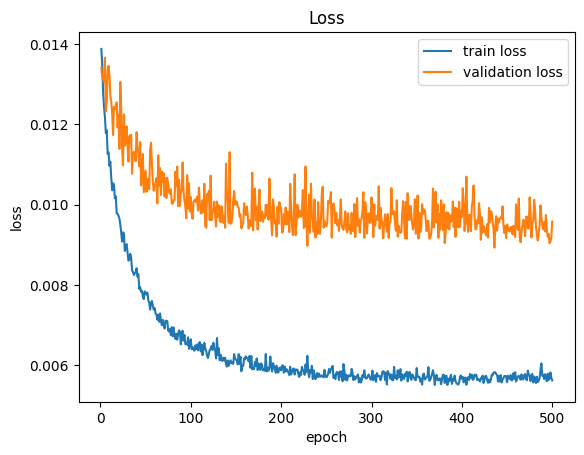

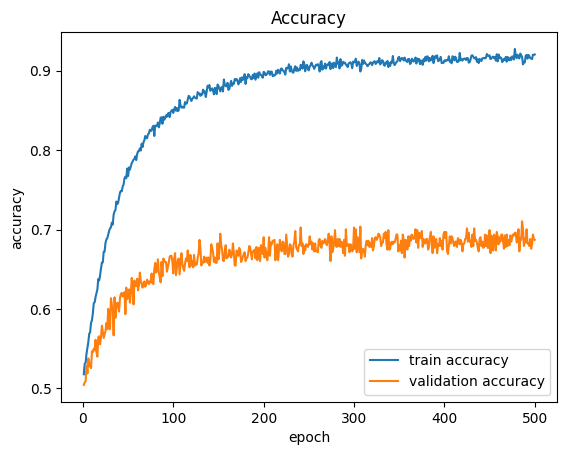

codes_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.014, validation loss: 0.023, train acc: 0.535, validation acc: 0.506
19270.1 examples/sec on cuda total training time:3.7 sec
Epoch: 40, train loss: 0.012, validation loss: 0.018, train acc: 0.575, validation acc: 0.516
19210.6 examples/sec on cuda total training time:7.4 sec
Epoch: 60, train loss: 0.011, validation loss: 0.018, train acc: 0.622, validation acc: 0.531
19419.5 examples/sec on cuda total training time:11.1 sec
Epoch: 80, train loss: 0.009, validation loss: 0.016, train acc: 0.665, validation acc: 0.550
24124.7 examples/sec on cuda total training time:14.7 sec
Epoch: 100, train loss: 0.009, validation loss: 0.016, train acc: 0.696, validation acc: 0.557
23795.5 examples/sec on cuda total training time:17.8 sec
Epoch: 120, train loss: 0.008, validation loss: 0.015, train acc: 0.723, validation acc: 0.582
24309.4 examples/sec on cuda total training time:21.0 sec
Epoch: 140, train loss

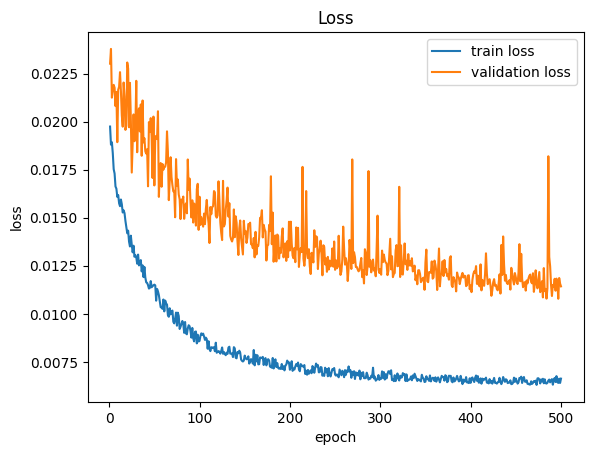

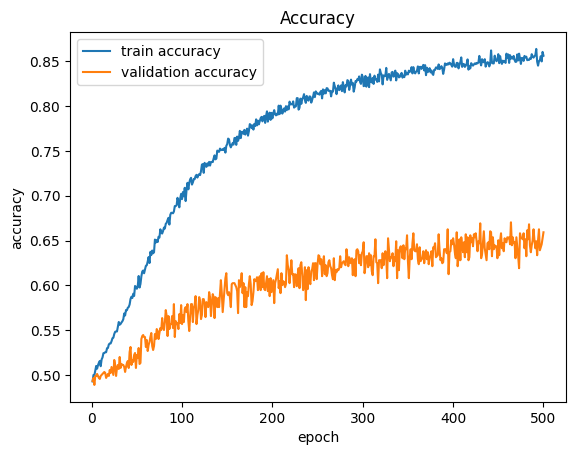

docs_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.012, validation loss: 0.027, train acc: 0.512, validation acc: 0.484
17991.4 examples/sec on cuda total training time:3.8 sec
Epoch: 40, train loss: 0.011, validation loss: 0.027, train acc: 0.532, validation acc: 0.509
22238.3 examples/sec on cuda total training time:7.2 sec
Epoch: 60, train loss: 0.011, validation loss: 0.026, train acc: 0.545, validation acc: 0.463
19792.4 examples/sec on cuda total training time:10.7 sec
Epoch: 80, train loss: 0.011, validation loss: 0.025, train acc: 0.561, validation acc: 0.507
23977.5 examples/sec on cuda total training time:13.9 sec
Epoch: 100, train loss: 0.011, validation loss: 0.025, train acc: 0.575, validation acc: 0.452
21792.1 examples/sec on cuda total training time:17.2 sec
Epoch: 120, train loss: 0.011, validation loss: 0.025, train acc: 0.575, validation acc: 0.503
23978.9 examples/sec on cuda total training time:20.5 sec
Epoch: 140, train loss:

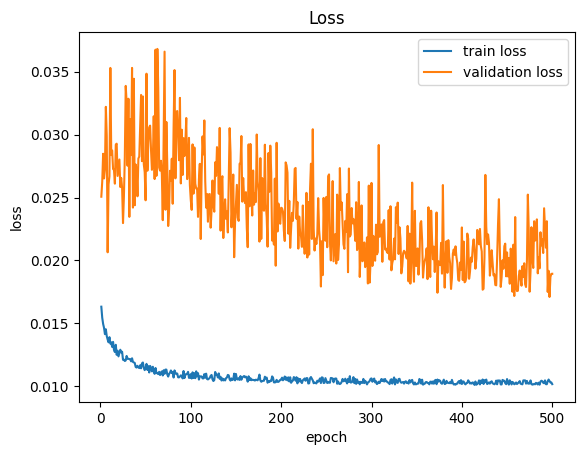

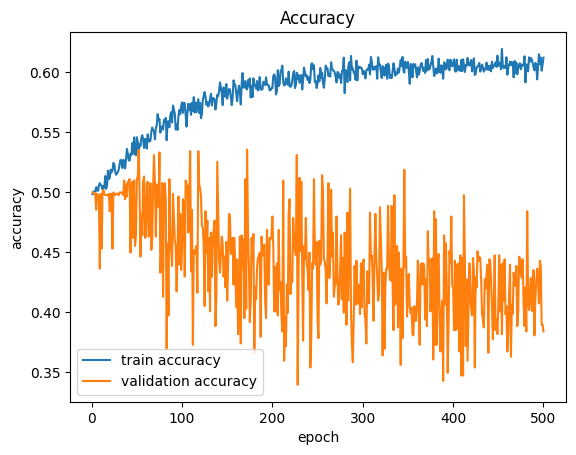

structure_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.010, validation loss: 0.012, train acc: 0.640, validation acc: 0.519
23655.3 examples/sec on cuda total training time:3.6 sec
Epoch: 40, train loss: 0.009, validation loss: 0.012, train acc: 0.702, validation acc: 0.526
24209.3 examples/sec on cuda total training time:7.0 sec
Epoch: 60, train loss: 0.009, validation loss: 0.012, train acc: 0.729, validation acc: 0.526
23017.0 examples/sec on cuda total training time:10.2 sec
Epoch: 80, train loss: 0.009, validation loss: 0.013, train acc: 0.748, validation acc: 0.552
22911.5 examples/sec on cuda total training time:13.4 sec
Epoch: 100, train loss: 0.009, validation loss: 0.012, train acc: 0.765, validation acc: 0.540
23088.0 examples/sec on cuda total training time:16.6 sec
Epoch: 120, train loss: 0.008, validation loss: 0.012, train acc: 0.774, validation acc: 0.557
18200.8 examples/sec on cuda total training time:20.0 sec
Epoch: 140, train 

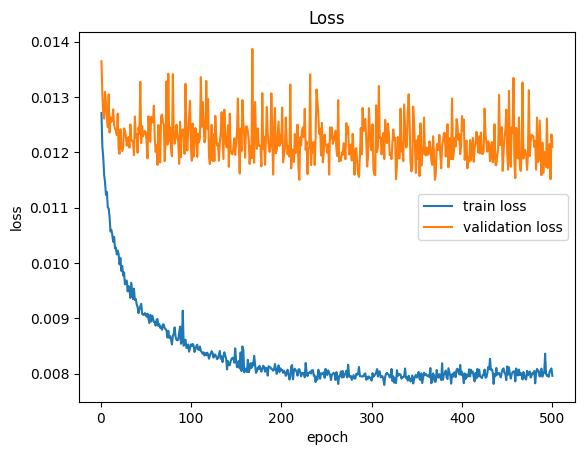

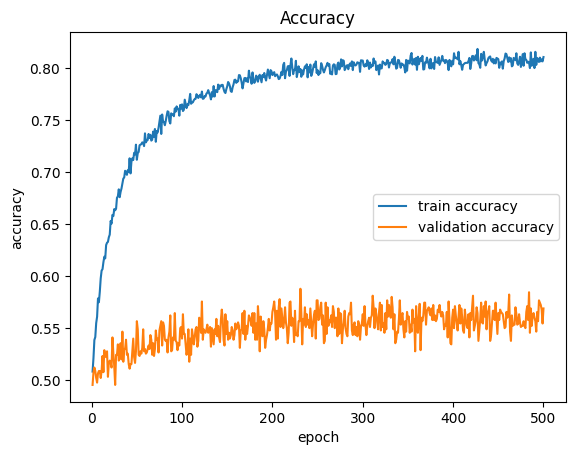

requirements_embeddings
------------------------------
Training starting
Epoch: 20, train loss: 0.010, validation loss: 0.015, train acc: 0.665, validation acc: 0.526
22409.2 examples/sec on cuda total training time:3.1 sec
Epoch: 40, train loss: 0.009, validation loss: 0.013, train acc: 0.745, validation acc: 0.528
21930.4 examples/sec on cuda total training time:6.2 sec
Epoch: 60, train loss: 0.008, validation loss: 0.012, train acc: 0.777, validation acc: 0.524
23332.8 examples/sec on cuda total training time:9.3 sec
Epoch: 80, train loss: 0.008, validation loss: 0.013, train acc: 0.811, validation acc: 0.511
21526.6 examples/sec on cuda total training time:12.5 sec
Epoch: 100, train loss: 0.008, validation loss: 0.012, train acc: 0.840, validation acc: 0.540
23269.8 examples/sec on cuda total training time:15.7 sec
Epoch: 120, train loss: 0.007, validation loss: 0.012, train acc: 0.845, validation acc: 0.542
23978.1 examples/sec on cuda total training time:18.8 sec
Epoch: 140, trai

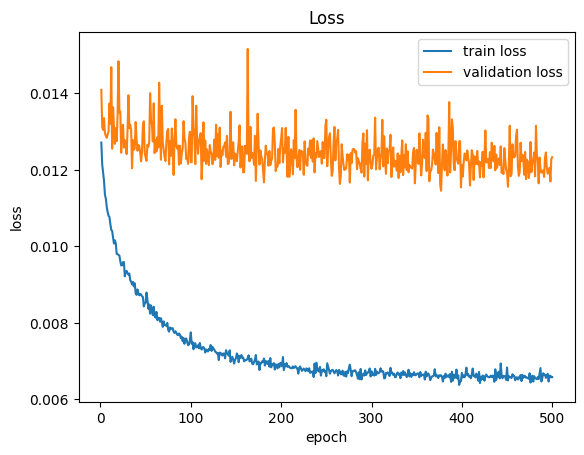

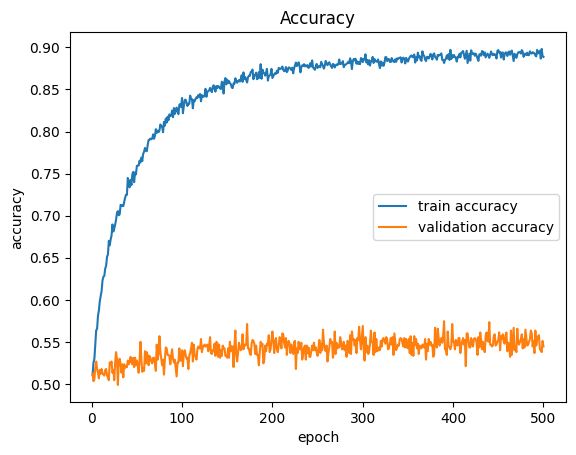

readme_embeddings
------------------------------


In [4]:
from utils import train_model, drawGraph
from torch.utils.data import DataLoader

batch_size = 64
epochs = 500
lr = 0.00001
weight_decay = 0.1

print(device)
for embedding_name in embedding_types:
    train_embedding = train_pair_embeddings[embedding_name]
    valid_embedding = valid_pair_embeddings[embedding_name]
    train_dataset = PairDataset(train_embedding, train_labels)
    valid_dataset = PairDataset(valid_embedding, valid_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    net = SingleEmbeddingClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay, betas=(0.8, 0.9))
    train_loss, test_loss, train_acc, test_acc = train_model(net, loss_fn, optimizer, epochs, device, train_loader, valid_loader, log_num=20, save_best=True, save_dir=embedding_name)
    drawGraph(train_loss, test_loss, train_acc, test_acc)
    print(embedding_name)
    print("-"*30)

In [7]:
class MergePairDataset(Dataset):
    def __init__(self, data, labels, embedding_types):
        self.data = []
        for i in range(len(labels)):
            e1 = []
            e2 = []
            for t in embedding_types:
                e1.append(data[t][i][0])
                e2.append(data[t][i][1])
            row = torch.cat(e1+e2, dim=0)
            self.data.append(row)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


class EmbeddingMLP(nn.Module):
    def __init__(self, size=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768 * size, 900 * size),
            nn.BatchNorm1d(900 * size),
            nn.ReLU(),
            nn.Linear(900 * size, 300 * size)
        )

    def forward(self, data):
        res = self.net(data)
        return res


class PairClassifier(nn.Module):
    def __init__(self, size=4):
        super().__init__()
        self.encoder = EmbeddingMLP(size)
        self.net = nn.Sequential(
            nn.Linear(300 * size * 2, 3000),
            nn.ReLU(),
            nn.Linear(3000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2),
        )

    def forward(self, data):
        e1 = self.encoder(data[:, :768 * 4])
        e2 = self.encoder(data[:, 768 * 4:])
        twins = torch.cat([e1, e2], dim=1)
        res = self.net(twins)
        return res

cuda
Training starting
Epoch: 20, train loss: 0.003, validation loss: 0.008, train acc: 0.965, validation acc: 0.771
6360.2 examples/sec on cuda total training time:11.5 sec
Epoch: 40, train loss: 0.002, validation loss: 0.006, train acc: 0.992, validation acc: 0.878
6367.0 examples/sec on cuda total training time:22.7 sec
Epoch: 60, train loss: 0.001, validation loss: 0.004, train acc: 0.996, validation acc: 0.912
6347.7 examples/sec on cuda total training time:34.0 sec
Epoch: 80, train loss: 0.002, validation loss: 0.004, train acc: 0.996, validation acc: 0.921
6354.8 examples/sec on cuda total training time:45.3 sec
Epoch: 100, train loss: 0.002, validation loss: 0.003, train acc: 0.994, validation acc: 0.929
6333.1 examples/sec on cuda total training time:56.6 sec
Epoch: 120, train loss: 0.002, validation loss: 0.003, train acc: 0.995, validation acc: 0.933
6320.7 examples/sec on cuda total training time:68.0 sec
Epoch: 140, train loss: 0.002, validation loss: 0.004, train acc: 0.9

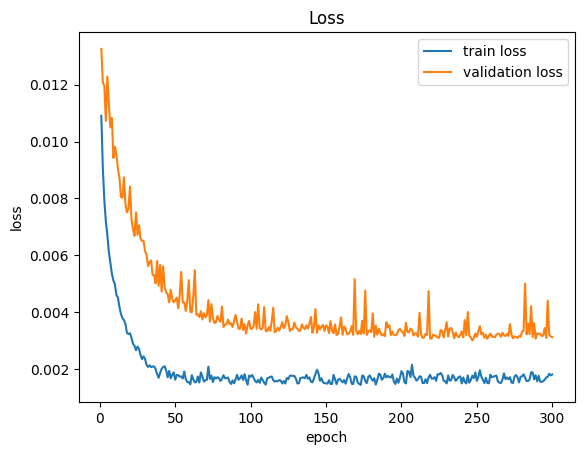

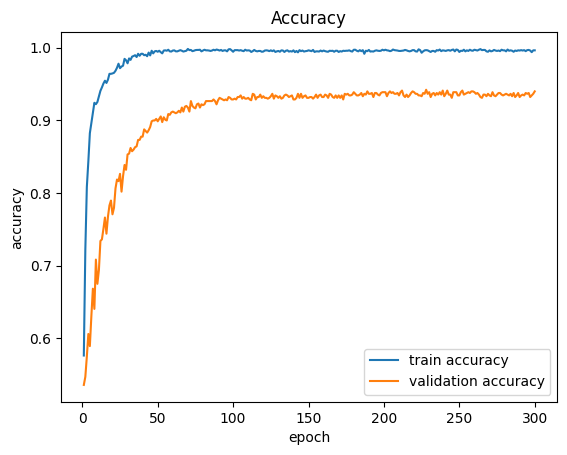

In [7]:
from utils import train_model, drawGraph
from torch.utils.data import DataLoader

batch_size = 64
epochs = 300
lr = 0.00003
weight_decay = 0.09

print(device)
train_embedding = train_pair_embeddings
valid_embedding = valid_pair_embeddings
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
train_dataset = MergePairDataset(train_embedding, train_labels, embedding_types)
valid_dataset = MergePairDataset(valid_embedding, valid_labels, embedding_types)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
net = PairClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay, betas=(0.8, 0.9))
train_loss, test_loss, train_acc, test_acc = train_model(net, loss_fn, optimizer, epochs, device, train_loader, valid_loader, log_num=20, save_best=True, save_dir="TWINS_MODEL")
drawGraph(train_loss, test_loss, train_acc, test_acc)

# Similarity

In [18]:
import torch
import utils
from torch.utils.data import DataLoader

batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = PairClassifier()
# net.load_state_dict(torch.load(".//TWINS_MODEL//Best_Param_2023-07-13 15-35-00.528684.pt"))
net.load_state_dict(torch.load(".//TWINS_MODEL//Best_Param_2023-07-24 20-50-00.157130.pt"))

net.eval()
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']

with open("..//Dataset//repo_info_train_embeddings_reduce.pkl", "rb") as f:
    data = pickle.load(f)

repo_names = list(data.keys())

ri1 = 100
ri2 = 100

def similarity(repo1, repo2, data, net):
    embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
    item = []
    matrix1 = []
    matrix2 = []
    net = net.cpu()
    with torch.no_grad():
        for t in embedding_types:
            matrix1.append(utils.mean_embeddings(data[repo1][t]))
            matrix2.append(utils.mean_embeddings(data[repo2][t]))
        item.append(torch.cat(matrix1 + matrix2))
        item.append(torch.cat(matrix2 + matrix1))
        # if repo1 == repo2:
        #     print('Similarity of "{}" and "{}": {:.2f}%\n'.format(repo1, repo2, 100))
        #     return 1.0, 0.0
        items = torch.stack(item)
        res = net(items)
        softmax = nn.Softmax(dim=1)
        similarity = torch.mean(softmax(res), dim=0)[1].cpu().numpy()
        dissimilarity = torch.mean(softmax(res), dim=0)[0].cpu().numpy()
    print('Similarity of "{}" and "{}": {:.2f}%\n'.format(repo1, repo2, similarity * 100))
    return similarity, dissimilarity

print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])

similarity(repo_names[ri1], repo_names[ri2], data, net)

django-cache-machine/django-cache-machine : Caching
django-cache-machine/django-cache-machine : Caching
Similarity of "django-cache-machine/django-cache-machine" and "django-cache-machine/django-cache-machine": 95.78%



(array(0.9577749, dtype=float32), array(0.04222514, dtype=float32))

In [19]:
ri1 = 100
ri2 = 168
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 121
ri2 = 168
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 121
ri2 = 100
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 168
ri2 = 32
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 200
ri2 = 32
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

ri1 = 200
ri2 = 121
print(repo_names[ri1], ":", data[repo_names[ri1]]['topic'])
print(repo_names[ri2], ":", data[repo_names[ri2]]['topic'])
similarity(repo_names[ri1], repo_names[ri2], data, net)

sim_id = []
sim_list = []
for i in range(200):
    sim, _ = similarity(repo_names[i], repo_names[i], data, net)
    if sim > 0.95:
        sim_id.append(i)
        sim_list.append(sim)
print(len(sim_id))
print(sim_list)

django-cache-machine/django-cache-machine : Caching
deanmalmgren/textract : Web Content Extracting
Similarity of "django-cache-machine/django-cache-machine" and "deanmalmgren/textract": 0.54%

jazzband/django-pipeline : Web Asset Management
deanmalmgren/textract : Web Content Extracting
Similarity of "jazzband/django-pipeline" and "deanmalmgren/textract": 18.01%

jazzband/django-pipeline : Web Asset Management
django-cache-machine/django-cache-machine : Caching
Similarity of "jazzband/django-pipeline" and "django-cache-machine/django-cache-machine": 5.99%

deanmalmgren/textract : Web Content Extracting
keon/algorithms : Algorithms
Similarity of "deanmalmgren/textract" and "keon/algorithms": 2.27%

zoofIO/flexx : GUI Development
keon/algorithms : Algorithms
Similarity of "zoofIO/flexx" and "keon/algorithms": 3.66%

zoofIO/flexx : GUI Development
jazzband/django-pipeline : Web Asset Management
Similarity of "zoofIO/flexx" and "jazzband/django-pipeline": 12.29%

Similarity of "jet-admin/j

Similarity of "MongoEngine/mongoengine" and "MongoEngine/mongoengine": 94.07%

Similarity of "pybee/toga" and "pybee/toga": 94.57%

Similarity of "google/yapf" and "google/yapf": 88.96%

Similarity of "Fizzadar/pyinfra" and "Fizzadar/pyinfra": 90.76%

Similarity of "istrategylabs/django-wordpress" and "istrategylabs/django-wordpress": 95.85%

Similarity of "zopefoundation/ZODB" and "zopefoundation/ZODB": 92.18%

Similarity of "boppreh/mouse" and "boppreh/mouse": 93.84%

Similarity of "justquick/django-activity-stream" and "justquick/django-activity-stream": 93.69%

Similarity of "benoitc/gunicorn" and "benoitc/gunicorn": 86.87%

Similarity of "prabhupant/python-ds" and "prabhupant/python-ds": 94.27%

Similarity of "marshmallow-code/marshmallow" and "marshmallow-code/marshmallow": 93.10%

Similarity of "coleifer/micawber" and "coleifer/micawber": 97.00%

Similarity of "getsentry/responses" and "getsentry/responses": 95.18%

Similarity of "joestump/python-oauth2" and "joestump/python-oau

In [11]:
from ignite.metrics import Accuracy
from ignite.metrics import Recall
from ignite.metrics import Precision

def evaluation(dataloader, model, loss_fn, device):
    print(device)
    test_acc = Accuracy()
    test_recall = Recall()
    test_precision = Precision()

    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_acc.update((pred, y))
            test_recall.update((pred, y))
            test_precision.update((pred, y))

    test_loss /= num_batches
    correct /= size

    # accuray,recall,precision in one epoach
    total_acc = test_acc.compute()
    total_recall = test_recall.compute()
    total_precision = test_precision.compute()
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, "
          f"Avg loss: {test_loss:>8f}, "
          f"ignite acc: {(100 * total_acc):>0.1f}%\n")
    print("recall of every test dataset class: ", total_recall)
    print("precision of every test dataset class: ", total_precision)

    test_precision.reset()
    test_acc.reset()
    test_recall.reset()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_types = ['codes_embeddings', 'docs_embeddings', 'requirements_embeddings', 'readme_embeddings']
all_pair_embeddings, all_labels = build_pair_data(all_embeddings, allLabels, embedding_types, balanced=False)
print("Size", len(all_labels))
all_dataset = MergePairDataset(all_pair_embeddings, all_labels, embedding_types)
dataloader = DataLoader(all_dataset, batch_size=64, shuffle=True, drop_last=False)
evaluation(dataloader, net, nn.CrossEntropyLoss(), device)

Size 207936
cuda
Test Error: 
 Accuracy: 92.1%, Avg loss: 0.193012, ignite acc: 92.1%

recall of every test dataset class:  tensor([0.9201, 0.9938], dtype=torch.float64)
precision of every test dataset class:  tensor([0.9999, 0.1194], dtype=torch.float64)


In [12]:
all_pair_embeddings, all_labels = build_pair_data(all_embeddings, allLabels, embedding_types, balanced=1.0)
print("Size", len(all_labels))
all_dataset = MergePairDataset(all_pair_embeddings, all_labels, embedding_types)
dataloader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
evaluation(dataloader, net, nn.CrossEntropyLoss(), device)

Before balanced: 207936
C 0: 2242
C 1: 2242
After balanced: 4484
Size 4484
cuda
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.149666, ignite acc: 95.4%

recall of every test dataset class:  tensor([0.9139, 0.9938], dtype=torch.float64)
precision of every test dataset class:  tensor([0.9932, 0.9203], dtype=torch.float64)
